In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import networkx as nx
np.set_printoptions(precision=5,linewidth=120,suppress=True)
import math
# the bisect module enables to easily keep an ordered list
# cf. https://docs.python.org/3.7/library/bisect.html
# useful for maintaining the OPEN list
import bisect
import quadprog

In [2]:
def display_result(world_mat, path):
    """
    This function displays a maze described in world_mat and a path inside the maze
    world_mat: a NxN matrix that contains the maze (0 for free path, -10 for obstacle)
    path: a list of elements numbered as the graph (i.e. from 0 to N**2-1)
    """
    N = world_mat.shape[0]
    display_mat = world_mat.copy()
    for el in path:
        display_mat[convert_to_matrixindex(el,N)] = 5
    plt.matshow(display_mat, cmap='Greys')
    
def convert_to_listindex(i,j,N):
    """
    This function converts a (i,j) matrix entry index to a list index for matrix of size N
    """
    return N*i+j

def convert_to_matrixindex(a,N):
    """
    This function converts a list entry a into a (i,j) matrix entry for matrix of size N
    """
    i = int(a/N) # the result of integer division
    j = int(a%N) # the  remainder of the division
    return i,j

def create_graph(world_mat):
    """
    This functions takes a NxN matrix in entry and creates a graph and a map of costs
    Since we use lists, for a world_mat of size NxN, we associate to the entry [i,j] of world_map
    the index a=N*i + j of the list
    output:
        graph: a list of neighbors  (indexed as explained above)
        cost: a N**2 x  N**2 array. Each entry cost[i,j] contains the cost of transitioning from node i to node j
            it is infinite if there is no edge from i to j
    """
    N = world_mat.shape[0]
    graph = []
    for i in range(N):
        for j in range(N):
            neigh = []
            if(i!=N-1):
                if(world_mat[i+1,j]==0):
                    neigh.append(N*(i+1)+j)
            if(i!=0):
                if(world_mat[i-1,j]==0):
                    neigh.append(N*(i-1)+j)
            if(j!=N-1):
                if(world_mat[i,j+1]==0):
                    neigh.append(N*i+j+1)
            if(j!=0):
                if(world_mat[i,j-1]==0):
                    neigh.append(N*i+j-1)
            graph.append(neigh)
    
    cost = np.ones([N*N,N*N]) * np.inf
    
    for i in range(N*N):
        for j in graph[i]:
            cost[i,j] = 1
    
    return graph, cost

[[ 0.  0.  0.  0. 10.]
 [ 0. 10. 10.  0.  0.]
 [ 0. 10.  0.  0.  0.]
 [ 0.  0.  0. 10.  0.]
 [ 0. 10. 10.  0.  0.]]


<IPython.core.display.Javascript object>


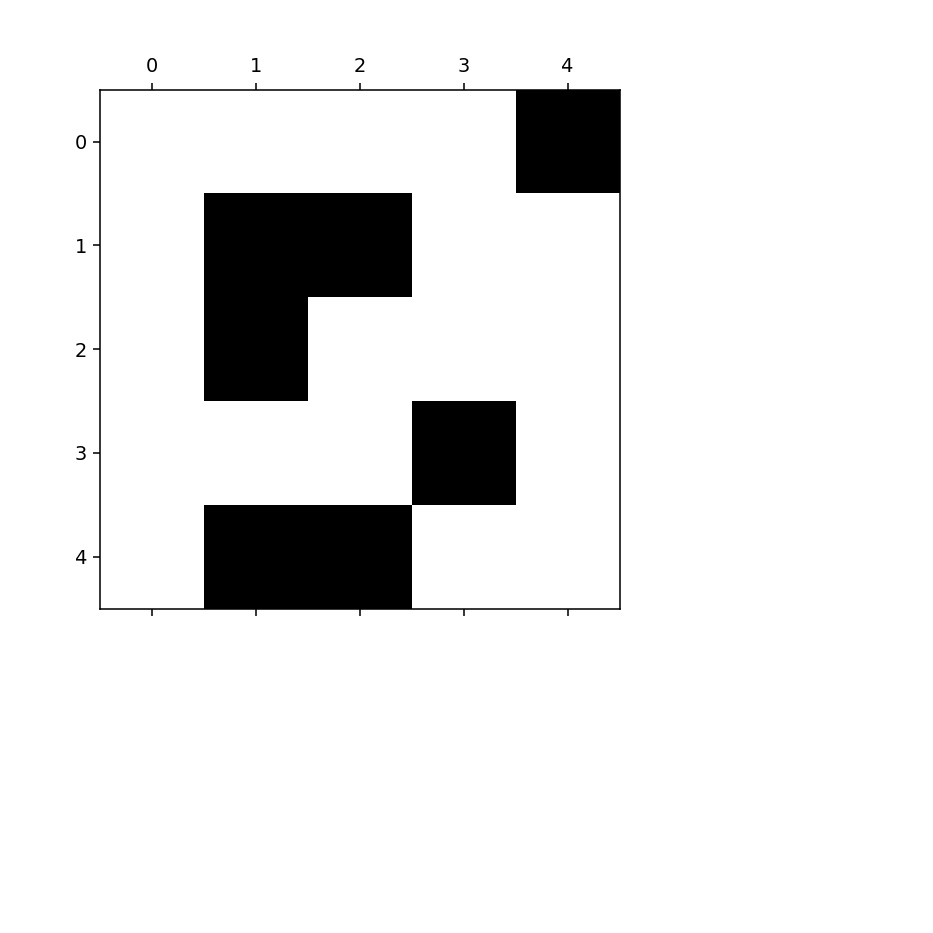

In [3]:
# let's create a map corresponding to the robot path planning example of lecture 3
# it is a 5x5 grid
world_map = np.zeros([5,5])
# and it contains obstacles which we mark as non 0
world_map[0,4] = 10
world_map[1,1:3] = 10
world_map[2,1] = 10
world_map[3,3] = 10
world_map[4,1:3] = 10

# we can print the matrix
print(world_map)

# we can now display the result
display_result(world_map, [])

[((0, 0), 1, 4), ((0, 0), 5, 1), ((1, 3), 2, 2), ((2, 2), 1, 3), ((3, 0), 1, 3), ((1, 4), 4, 1), ((4, 3), 1, 2)]


<IPython.core.display.Javascript object>


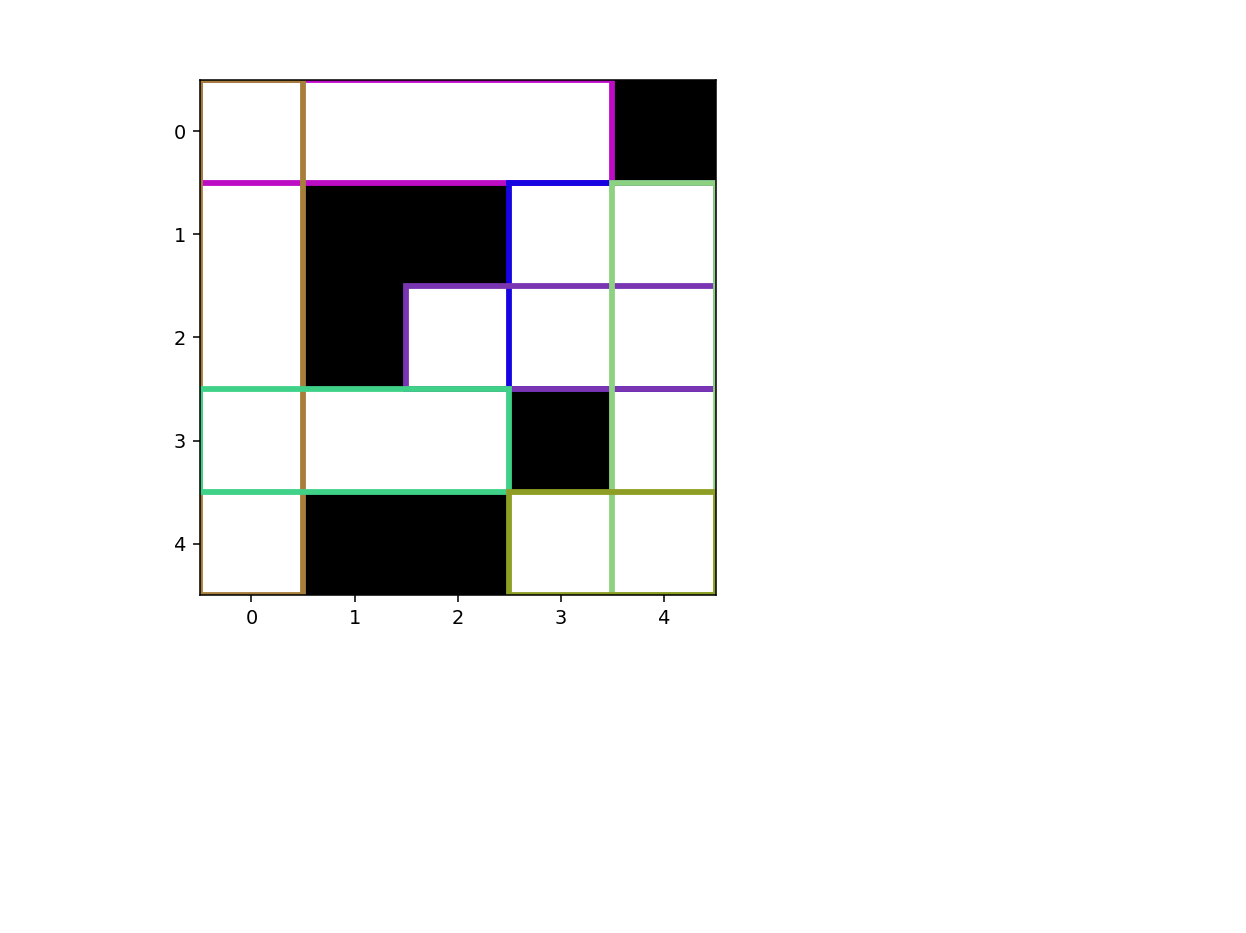

In [ ]:
#!/usr/bin/env python3
import os
import numpy as np
import open3d as o3d
import random
import scipy.ndimage as ndi
import heapq
import rclpy
from rclpy.node import Node
from std_msgs.msg import Header
from sensor_msgs.msg import PointCloud2
from visualization_msgs.msg import Marker, MarkerArray
import sensor_msgs_py.point_cloud2 as pc2

# For plotting colors in ROS2 markers, we use hex strings converted to RGB
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return [int(hex_color[i:i+2], 16)/255.0 for i in (0, 2, 4)]

#############################################
# Debug Helper
#############################################
def debug_print(msg, *values):
    print("[DEBUG]", msg, *values)

#############################################
# 1. 2D Free-Flight Corridor Decomposition (2D logic)
#############################################
def solveHorzEdges(world_map):
    (h, w) = world_map.shape
    edges = []
    # Find all the rows that contain an obstacle (value==10)
    for i in range(h):
        for j in range(w):
            if world_map[i, j] == 10:
                if len(edges) == 0:
                    edges.append(i)
                else:
                    if edges[-1] != i:
                        edges.append(i)
    return edges

def expandLeft(count, temp_map, row):
    (h, w) = temp_map.shape
    width = 0
    width_l = count - 1 
    block_val = 10 * h * w
    while width_l >= 0:
        if temp_map[row, width_l] == block_val:
            break
        width_l -= 1
        width += 1
    return width_l, width

def expandRight(count, temp_map, row):
    (h, w) = temp_map.shape
    block_val = 10 * h * w
    width = 0
    while (count + width < w) and (temp_map[row, count + width] != block_val):
        width += 1
    return width

def solveSafeFlight(world_map):
    """
    Decomposes the entire free space in a 2D occupancy grid (world_map)
    into free-flight corridors. The occupancy map should use 10 for obstacles
    and 0 for free space.
    Returns a list of corridors as tuples: ((row, col), height, width)
    where (row, col) is the upper-left corner in grid indices.
    """
    edges = solveHorzEdges(world_map)
    (h, w) = world_map.shape
    temp_map = world_map.copy() * h * w  # Scale to create a high block value
    rect_list = []
    block_val = 10 * h * w
    for i in range(h):
        count = 0
        while count < w:
            if temp_map[i, count] == 0:
                # Start a new rectangle
                rect_start = (i, count)
                width = 1
                height = 1
                temp_map[i, count] = 1  # mark as explored
                # Expand left
                width_l, width_x = expandLeft(count, temp_map, i)
                rect_start = (i, width_l + 1)
                width += width_x
                # Expand right
                width_x = expandRight(count, temp_map, i)
                width += width_x
                count += width_x  # move count
                width -= 1
                # Expand upward
                count_h = i - 1
                while count_h >= 0:
                    row_sum = np.sum(temp_map[count_h, rect_start[1]:rect_start[1] + width])
                    if row_sum >= block_val:
                        break
                    rect_start = (rect_start[0] - 1, rect_start[1])
                    height += 1
                    count_h -= 1
                # Expand downward
                count_h = i + 1
                while count_h < h:
                    row_sum = np.sum(temp_map[count_h, rect_start[1]:rect_start[1] + width])
                    if row_sum >= block_val:
                        break
                    height += 1
                    count_h += 1
                # Mark explored area
                temp_map[rect_start[0]:rect_start[0] + height, rect_start[1]:rect_start[1] + width] = np.ones((height, width))
                rect_list.append((rect_start, height, width))
            else:
                count += 1
    return rect_list

#############################################
# 2. ROS2 Publisher Node for RViz2 Visualization
#############################################
class RVizPublisher(Node):
    def __init__(self, pc_points, corridors, grid_resolution, origin):
        """
        pc_points: list of [x,y,z] for the point cloud.
        corridors: list of tuples ((row, col), height, width) in grid indices.
        grid_resolution: resolution of the 2D grid (meters per cell).
        origin: [x,y] coordinate corresponding to grid index (0,0).
        """
        super().__init__('rviz_publisher')
        qos = rclpy.qos.QoSProfile(
            reliability=rclpy.qos.QoSReliabilityPolicy.RELIABLE,
            history=rclpy.qos.QoSHistoryPolicy.KEEP_LAST,
            depth=10
        )
        self.pc_pub = self.create_publisher(PointCloud2, '/point_cloud', qos)
        self.marker_pub = self.create_publisher(MarkerArray, '/free_corridors', qos)
        self.timer = self.create_timer(1.0, self.publish_all)
        
        self.frame_id = "map"
        self.pc_points = pc_points
        self.corridors = corridors
        self.grid_resolution = grid_resolution
        self.origin = origin  # 2D origin of grid (x,y)
        
        self.get_logger().info('RVizPublisher node for corridors initialized')
    
    def publish_all(self):
        now = self.get_clock().now().to_msg()
        self.publish_point_cloud(now)
        self.publish_corridor_markers(now)
        self.get_logger().info("Published point cloud and corridor markers.")
    
    def publish_point_cloud(self, stamp):
        header = Header()
        header.stamp = stamp
        header.frame_id = self.frame_id
        pc_msg = pc2.create_cloud_xyz32(header, self.pc_points)
        self.pc_pub.publish(pc_msg)
    
    def publish_corridor_markers(self, stamp):
        marker_array = MarkerArray()
        marker_id = 0
        # For each corridor, create a flat cube (with a small z extent)
        for corridor in self.corridors:
            (grid_start, height, width) = corridor
            # Convert grid indices to world coordinates (only x and y)
            # Assume grid index (0,0) corresponds to self.origin and each cell has self.grid_resolution size.
            x0 = self.origin[0] + grid_start[1] * self.grid_resolution
            y0 = self.origin[1] + grid_start[0] * self.grid_resolution
            # The corridor extends width cells in x and height cells in y.
            corridor_width = width * self.grid_resolution
            corridor_height = height * self.grid_resolution
            # For visualization, use a very small z thickness (e.g., 0.1m)
            z_thickness = 0.1
            # The center of the corridor in world coordinates:
            center_x = x0 + corridor_width / 2.0
            center_y = y0 + corridor_height / 2.0
            center_z = 0.0  # on the ground plane
            
            marker = Marker()
            marker.header.frame_id = self.frame_id
            marker.header.stamp = stamp
            marker.ns = "corridors"
            marker.id = marker_id
            marker_id += 1
            marker.type = Marker.CUBE
            marker.action = Marker.ADD
            marker.pose.position.x = center_x
            marker.pose.position.y = center_y
            marker.pose.position.z = center_z
            marker.pose.orientation.w = 1.0
            marker.scale.x = corridor_width
            marker.scale.y = corridor_height
            marker.scale.z = z_thickness
            # Assign a random color for visualization.
            rand_color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
            r, g, b = hex_to_rgb(rand_color)
            marker.color.r = r
            marker.color.g = g
            marker.color.b = b
            marker.color.a = 0.5
            marker_array.markers.append(marker)
        
        self.marker_pub.publish(marker_array)

#############################################
# 3. Main Routine: Compute Corridors & Launch ROS2 Publisher
#############################################
def main():
    # Load a 3D point cloud (Nx3 numpy array)
    pc_file = "/home/raghuram/ARPL/cuboid_decomp/cuboid_decomp-/pointcloud/pointcloud_gq/point_cloud_gq.npy"
    points = np.load(pc_file)
    if points.dtype.names is not None:
        points = np.vstack([points[name] for name in ('x', 'y', 'z')]).T

    # For corridor decomposition, we create a 2D occupancy map.
    # Project the point cloud onto the XY plane.
    # We'll set a resolution (meters per cell) and mark a cell as occupied if any point falls into it.
    grid_resolution = 0.2
    # Determine bounds from point cloud (XY only)
    x_min, y_min = np.min(points[:, :2], axis=0)
    x_max, y_max = np.max(points[:, :2], axis=0)
    # Define grid dimensions
    grid_width = int(np.ceil((x_max - x_min) / grid_resolution))
    grid_height = int(np.ceil((y_max - y_min) / grid_resolution))
    # Initialize occupancy map with zeros (free space)
    world_map = np.zeros((grid_height, grid_width), dtype=np.uint8)
    
    # Fill in obstacles: For simplicity, mark a cell as an obstacle (value 10) if any point falls into it.
    for pt in points:
        col = int((pt[0] - x_min) / grid_resolution)
        row = int((pt[1] - y_min) / grid_resolution)
        world_map[row, col] = 10  # mark as obstacle

    debug_print("2D occupancy map created with shape:", world_map.shape)
    
    # Decompose free space into corridors using your 2D logic
    corridors = solveSafeFlight(world_map)
    debug_print("Found corridors:", corridors)
    
    # For ROS2 visualization, convert the original point cloud to a list of [x,y,z]
    pc_points = points.tolist()
    
    # The origin of the grid (world coordinate of grid index (0,0))
    origin = [x_min, y_min]
    
    # Initialize ROS2 and start the publisher node.
    rclpy.init()
    publisher_node = RVizPublisher(pc_points, corridors, grid_resolution, origin)
    try:
        rclpy.spin(publisher_node)
    except KeyboardInterrupt:
        pass
    finally:
        publisher_node.destroy_node()
        rclpy.shutdown()

if __name__ == "__main__":
    main()


In [5]:
class RectNode:
    def __init__(self, rect_value,index):
        self.rect = rect_value
        self.n = [] #Neighbors
        self.index = index
    #Returns true if x and y are inside the square
    def isMember(self, x,y):
        start = self.rect[0]
        if(start[1] <=x) and(x<=start[1]+self.rect[2]-1):
            if(start[0] <=y) and(y<=start[0]+self.rect[1]-1):
                return True
        return False 
    def addNeighbor(self, rect_node):
        for i in range(len(self.n)):
            if self.n[i] == rect_node.index:
                return False
        self.n.append(rect_node.index)
        
def find_point(x, y, rect_list):
    corridors = []
    for i in range(len(rect_list)):
        curr_rect = rect_list[i]
        start = curr_rect[0]
        if(start[1] <=x) and(x<=start[1]+curr_rect[2]-1):
            if(start[0] <=y) and(y<=start[0]+curr_rect[1]-1):
                corridors.append(i)
    return corridors

#Generates a graph head is top node
#Declare Height and width of graph
def generateAdjList(rect_list):
    node_list = []
    #Add every item to node_list
    for i in range(len(rect_list)):
        curr_node = RectNode(rect_list[i],i)
        node_list.append(curr_node)
    for i in range(len(node_list)):
        curr_rect = node_list[i].rect
        start = curr_rect[0]
        x = start[1]-1
        y = start[0]-1
        x_lim = x+curr_rect[2]+2
        y_lim = y+curr_rect[1]+2
        #Filler value at the end
        corner_list = [(x,y),(x_lim-1,y),(x,y_lim-1),(x_lim-1,y_lim-1)]
        index_corner = 0
        for j in range(y,y_lim):
            for k in range(x,x_lim):
                if((k == corner_list[index_corner][0]) and (j == corner_list[index_corner][1])):
                    index_corner+=1
                else:
                    for l in range(len(node_list)):
                        if l!=i:
                            if node_list[l].isMember(k,j):
                                    node_list[i].addNeighbor(node_list[l])

    return node_list;

#Return true if the boxes overlap
def boxOverlap(bound_low, bound_up, corners):
    indent = [(0.01,0.01),(-0.01,0.01),(0.01,-0.01),(-0.01,-0.01)]
    for j in range(len(corners)):
        #indent the corners a little to see if there exists points where they are in the inside by 0.01
        x = corners[j][0]+indent[j][0]
        y = corners[j][1]+indent[j][1]
        if(bound_low[0] <x) and(x<bound_up[0]):
            if(bound_low[1] <y) and(y<bound_up[1]):
                return True;
    return False;

def boxShorten(dist, path):
    new_path = []
    for i in range(len(path)):
        obj = path[i]
        start = obj[0]
        length_x = obj[2]-dist
        length_y = obj[1]-dist
        center_x = obj[2]*0.5+start[1] - length_x*0.5
        center_y = obj[1]*0.5+start[0]- length_y*0.5
        new_path.append(((center_y,center_x),length_y,length_x))
    return new_path
        

#If there exists no overlap between two corridors add a object inbetween 
def additionalBoundingBox(path):
    new_path  = []
    new_path.append(path[0]);
    l = len(path)-1
    for i in range(l):
        first_box = path[i];
        next_box = path[i+1];
        first_box_C1 = first_box[0]
        first_box_C2 = (first_box[0][0]+first_box[1],first_box[0][1]+first_box[2])
        corners_f = [first_box_C1, (first_box_C2[0],first_box_C1[1]),(first_box_C1[0],first_box_C2[1]),first_box_C2]

        next_box_C1 = next_box[0]
        next_box_C2 = (next_box[0][0]+next_box[1],next_box[0][1]+next_box[2])
        corners_next = [next_box_C1, (next_box_C2[0],next_box_C1[1]),(next_box_C1[0],next_box_C2[1]),next_box_C2]
        if boxOverlap(first_box_C1,first_box_C2,corners_next) !=True:
            if boxOverlap(next_box_C1,next_box_C2,corners_f) !=True:
                H = first_box[1]+next_box[1]
                W = min([first_box_C2[1],next_box_C2[1]]) - max([first_box_C1[1],next_box_C1[1]])
                #Second box is underneath first box in Y
                if first_box_C1[0] == next_box_C2[0]:
                    start = (next_box[0][0],max(first_box[0][1],next_box[0][1]))
                #Second box is above first box in Y
                if next_box_C1[0] == first_box_C2[0]:
                    start = (first_box[0][0],max(first_box[0][1],next_box[0][1]))
                new_path.append((start,H,W))
        new_path.append(path[i+1])
    return new_path

In [6]:
def quadprog_solve_qp(P, q, G=None, h=None, A=None, b=None):
    qp_G = .5 * (P + P.T)   # make sure P is symmetric
    qp_a = -q
    
    if A is not None:
        qp_C = -np.vstack([A, G]).T
        qp_b = -np.hstack([b, h])
        meq = A.shape[0]
    else:  # no equality constraint
        qp_C = -G.T
        qp_b = -h
        meq = 0

    return quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)[0]

In [7]:
import operator as op
from functools import reduce
#(n r) n!/(r!(n-r)!)
def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom  # or / in Python 2

#Bernstein polynomila evaluation
def bernEval(n,i,t):
    return ncr(n,i)*((1-t)**(n-i))*(t**i)

#return Ax = b and Gx < h constraints
def genBmatrix(path, start, end,tf,dim=0):
    numberVar =  len(path)*5
    equalConstr = 2+(len(path)-1)*2
    inequalConstr = len(path)*5
    A = np.zeros((equalConstr,numberVar)) #Start stop Continuity velocity 
    b = np.zeros((equalConstr)) #Endpoint Constraint
    G = np.zeros((inequalConstr*2,numberVar)) # Use the boundig box
    h = np.zeros((inequalConstr*2))
    A[0,0] = 1
    b[0] = start[dim]
    A[1,numberVar-1] = 1
    b[1] = end[dim]
    #Construct Equality and Inequality Constraints
    for i in range(len(path)-1):
        #Endpoint Continuity constraint
        #Ensure tagent is equal for velocity
        #A[n-1]
        #Constant velocity
        A[i*2+2,5*i+3] = (4/tf[i])
        A[i*2+2,5*i+4] = -(4/tf[i])
        A[i*2+2,5*i+5] = -(4/tf[i+1]) 
        A[i*2+2,5*i+6] = (4/tf[i+1]) 
        #Endpoints must line up 
        A[i*2+3,5*i+4] = 1
        A[i*2+3,5*i+5] = -1
    for i in range(inequalConstr):
        index = math.floor(i/5)
        rect = path[index][0]
        G[2*i,i] = 1
        G[2*i+1,i] = -1
        h[2*i] = rect[dim]+ path[index][1+dim] #+ 0.1
        h[2*i+1] = -rect[dim]# +0.9
    return A,b,G,h

def genObj(path):
    numberVar =  len(path)*5
    inequalConstr = len(path)*5
    G = np.zeros((inequalConstr*2,numberVar)) # Use the boundig box
    for i in range(inequalConstr):
        G[2*i,i] = 1
        G[2*i+1,i] = -1
    return np.matmul(G.T,G)

#Creates a matrix that when multiplied gives you your derivative
#Multiply with the Bernstein Basis Evaluation one degree lower to get the derivative
def bezierDerivMatrix(n,order= 1,tf=1.0):
    val = pow((1 / tf ),order);
    for i in range(order):
        val = val*(n-i)
    Dm = np.zeros((n+1,n-order+1));
    conv_filt = np.zeros(order+1);
    conv_filt[0] =-1;
    conv_filt[1] = 1
    for i in range(1,order):
        conv_filt[1:] -= conv_filt[:order]
    for i in range(n-order+1):
        q = min(i+order+1,n+1)
        for j in range(i,q):
            Dm[j, i] = val*conv_filt[j-i]
    return Dm

def genCostNorm(n,derivOrder, tf):
    #Side matrices
    dm =  bezierDerivMatrix(n,derivOrder,tf);
    #power
    factor = tf/(2*(n-derivOrder))
    #Main matrices
    q = np.zeros((n-derivOrder+1,n-derivOrder+1));
    bigN = 2*(n-derivOrder)
    smallN = n-derivOrder
    q = np.identity(n-derivOrder+1)
    for i in range(n-derivOrder+1):
        for j in range(n-derivOrder+1):
              q[i,j] = 1/(ncr(bigN,(i+j))/(ncr(smallN,i)*ncr(smallN,j)))
    return factor*((dm @ q) @ dm.T)
              
def evalCoeff(t_in, tf, coeff, N):
    index=0
    while(t_in-tf[index])>0:
        t_in -=tf[index]
        index+=1
        if index == len(tf):
            return 
    #Normalize time
    t_in = t_in/tf[index]
    poly_eval = 0
    for i in range(N+1):
        poly_eval += coeff[index*5+i]*bernEval(4,i,t_in)
    return poly_eval   

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) >= 0)


[((0, 0), 1, 4), ((0, 0), 5, 1), ((1, 3), 2, 2), ((2, 2), 1, 3), ((3, 0), 1, 3), ((1, 4), 4, 1), ((4, 3), 1, 2)]


<IPython.core.display.Javascript object>


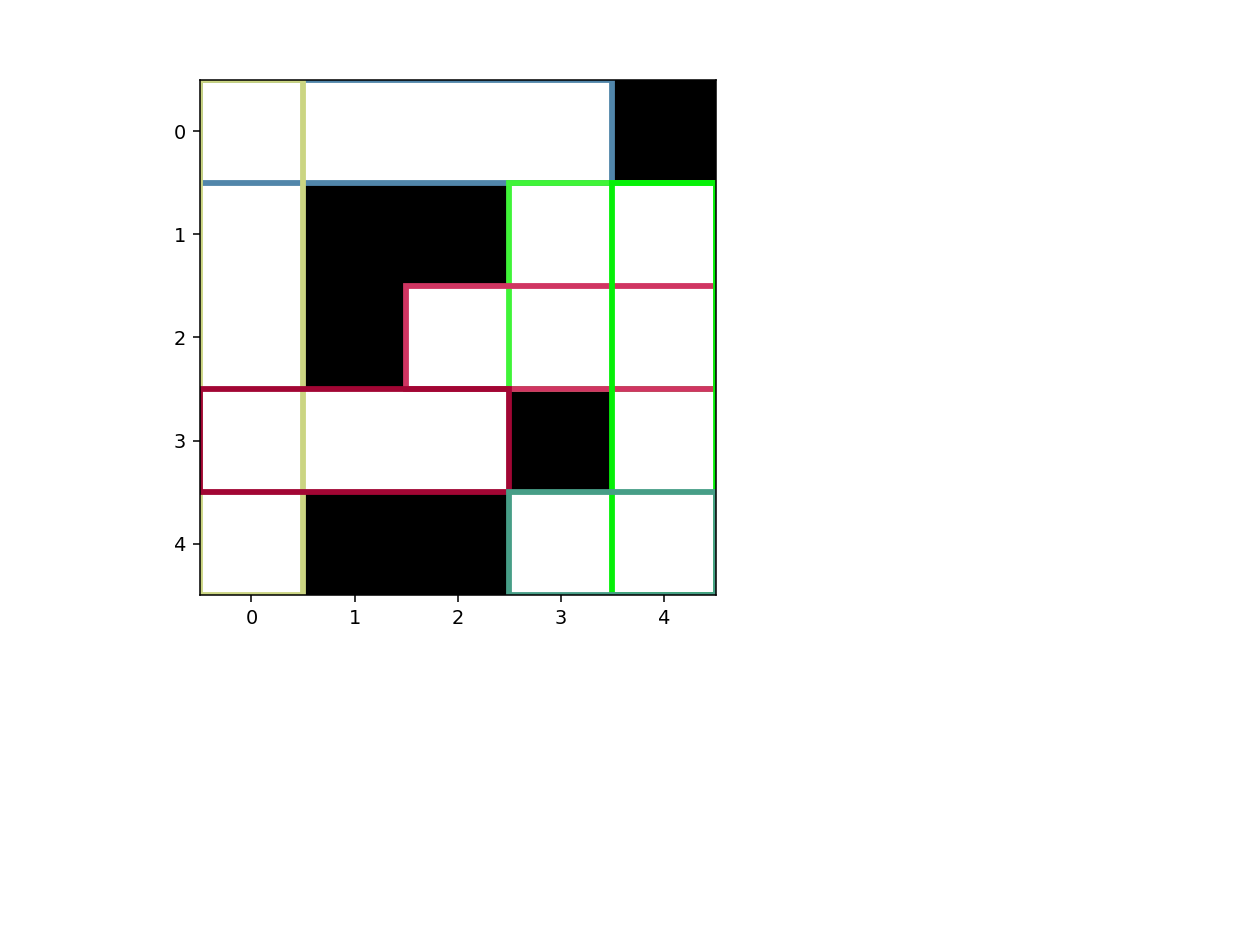

[1, 2]


<IPython.core.display.Javascript object>


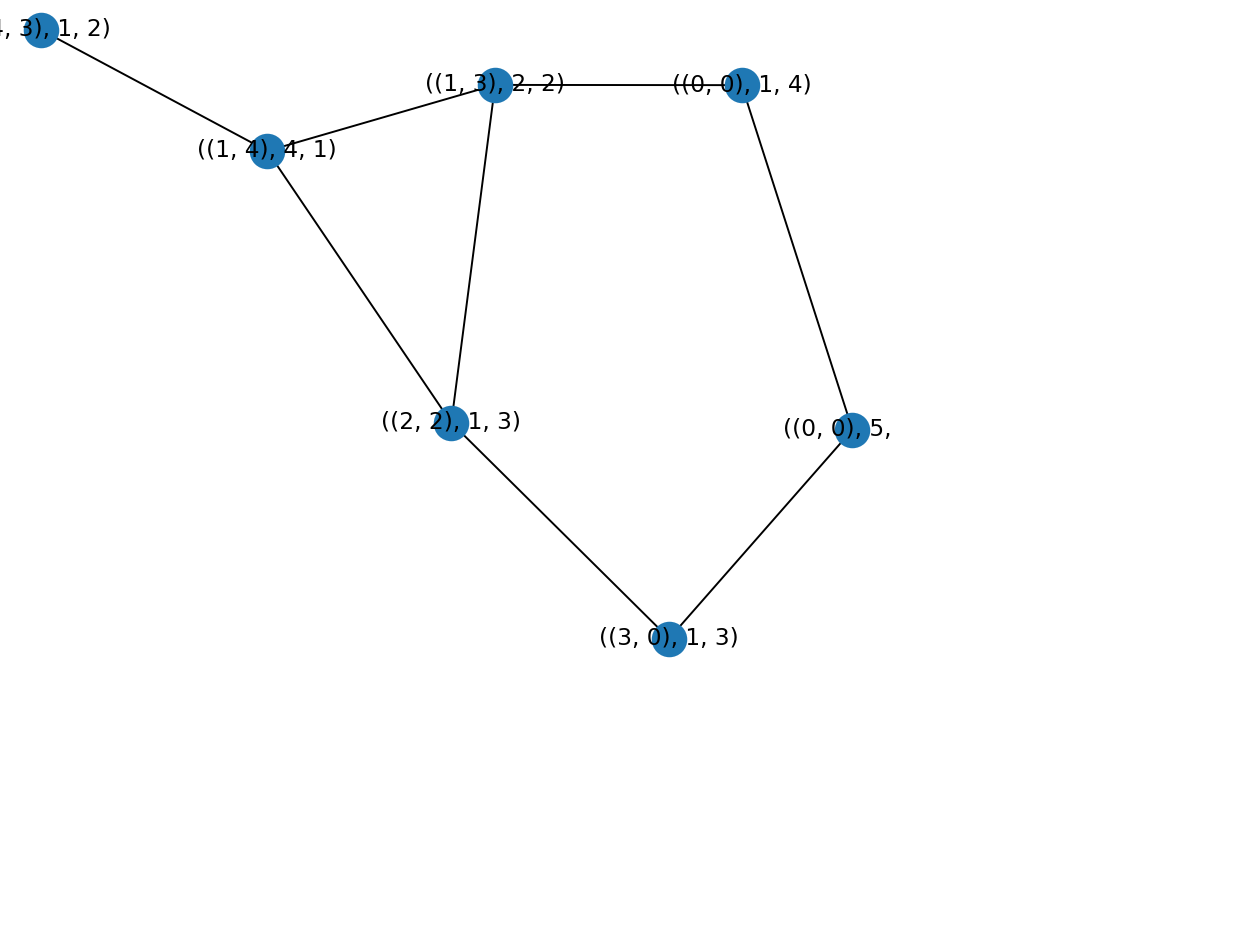

In [9]:
#Color path red
#Left shift all the boxes
rect_list = solveSafeFlight(world_map)
print(rect_list)
fig, ax = plt.subplots()
ax.imshow(1/(world_map+0.1), cmap='gray')
import random
number_of_colors = len(rect_list)
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
    for i in range(number_of_colors)]
for i in range(len(rect_list)):
    rect_obj = rect_list[i]
    start = (rect_obj[0][1]-0.5,rect_obj[0][0]-0.5)
    rect = patches.Rectangle(start, rect_obj[2],rect_obj[1], linewidth=3, edgecolor=color[i], facecolor='none')
    ax.add_patch(rect)
plt.show()
graph_list = generateAdjList(rect_list);
print(graph_list[0].n)
G = nx.Graph()
#Add nodes
for i in range(len(graph_list)):
    G.add_node(graph_list[i].rect)
#Add edges
for i in range(len(graph_list)):
    curr_node = graph_list[i]
    start_str = graph_list[i].rect
    for j in range(len(curr_node.n)):
        end_str = graph_list[curr_node.n[j]].rect
        e = (start_str, end_str)
        G.add_edge(*e,color='k')
plt.figure()
nx.draw(G, with_labels = True)


<IPython.core.display.Javascript object>


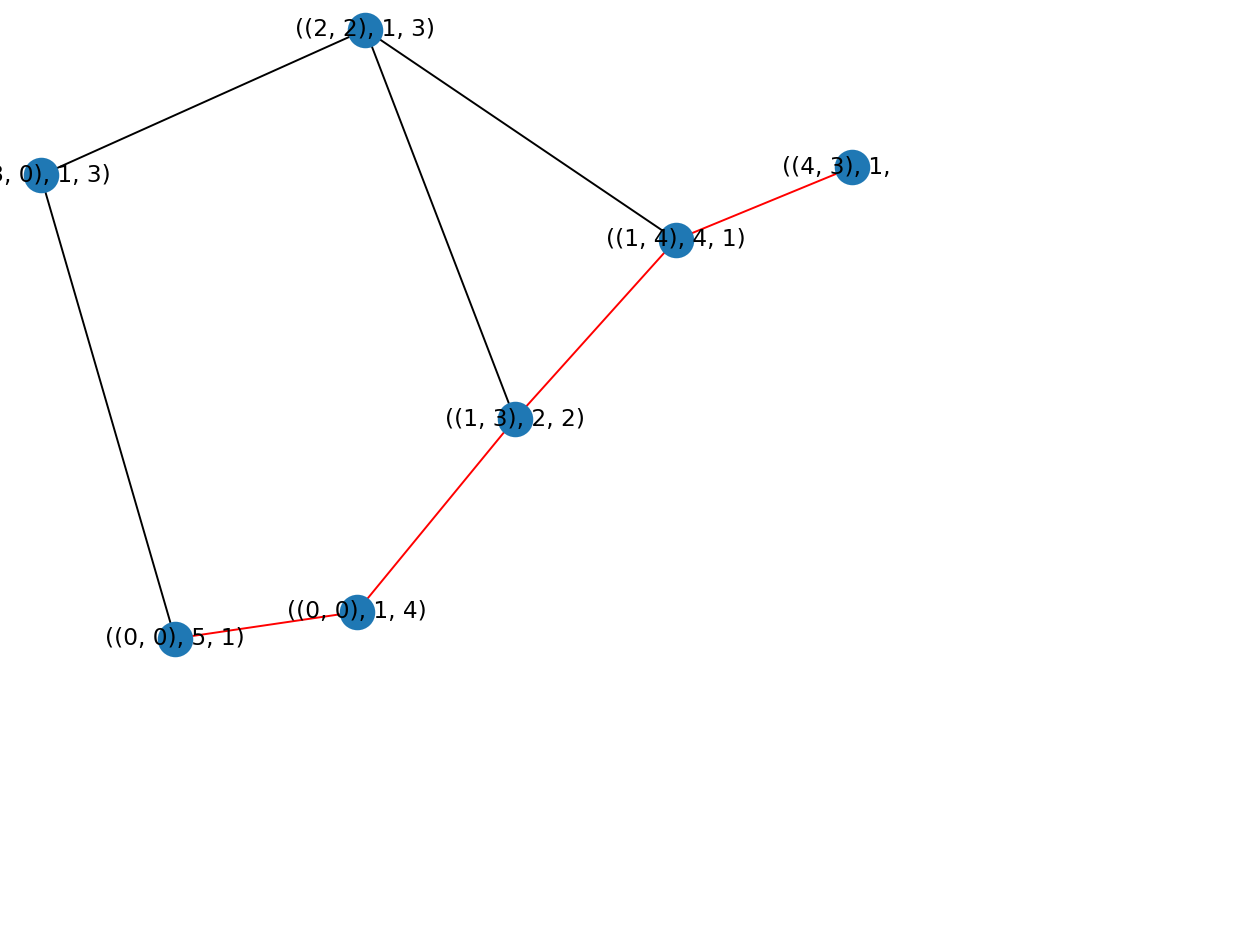

<IPython.core.display.Javascript object>


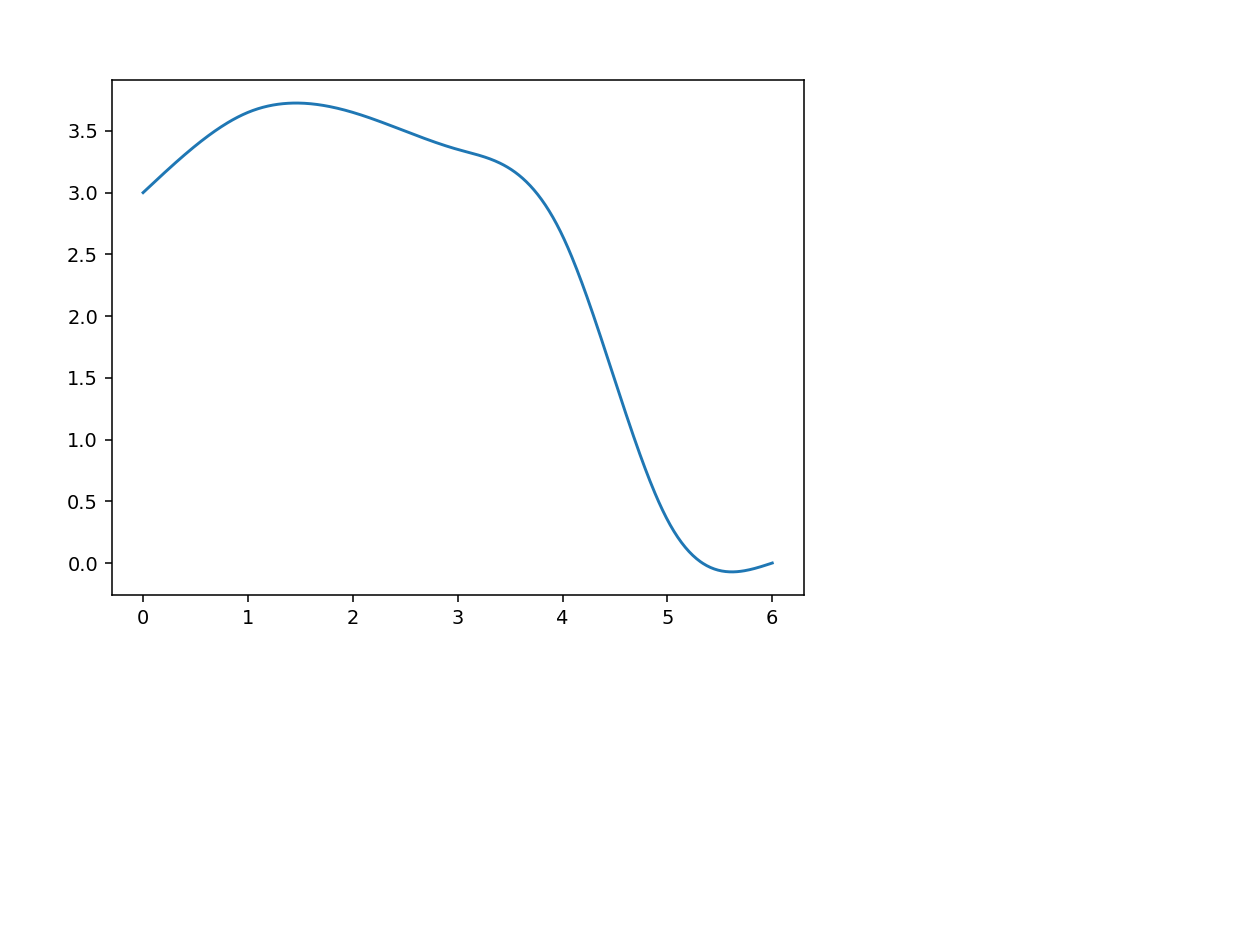

<IPython.core.display.Javascript object>


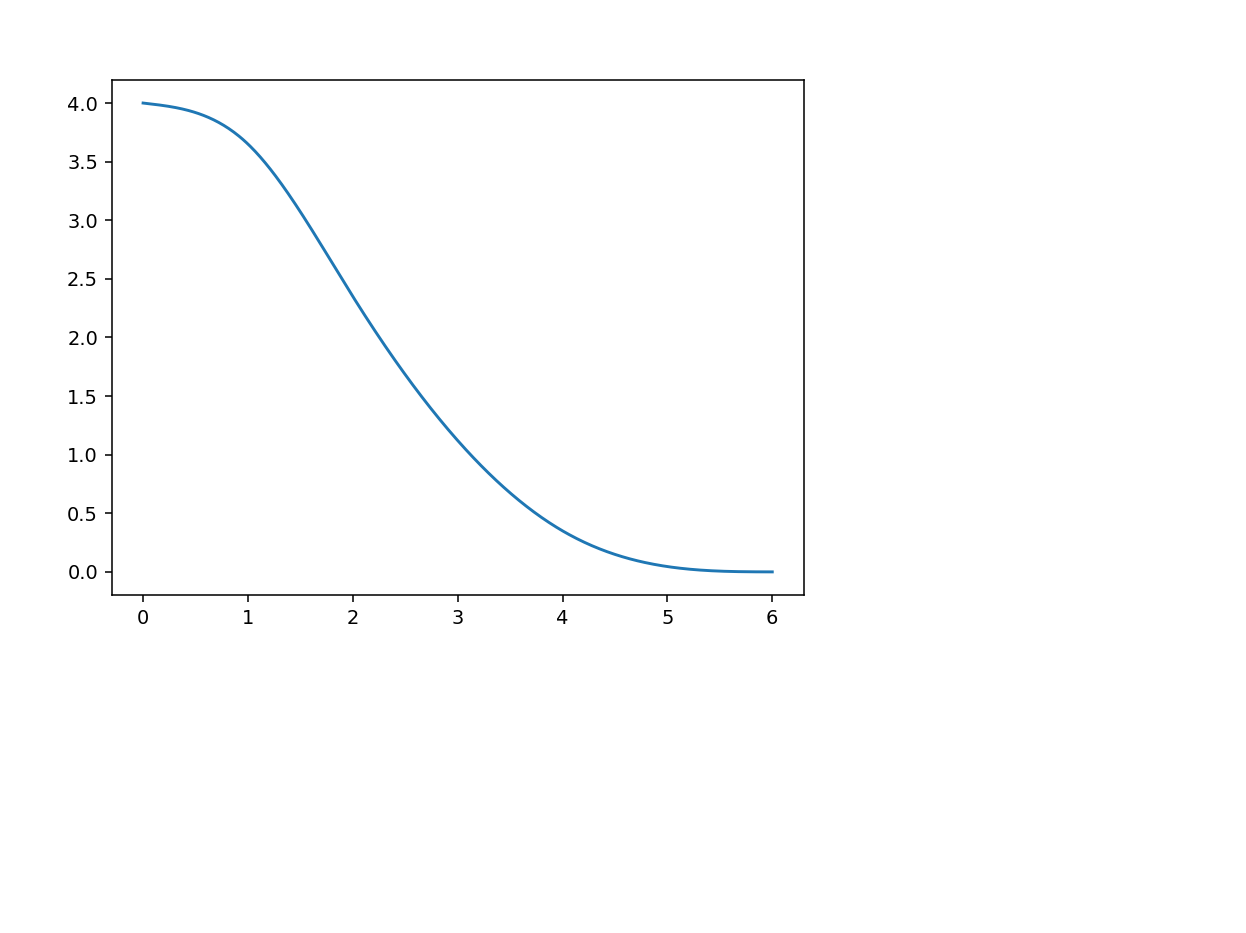

<IPython.core.display.Javascript object>


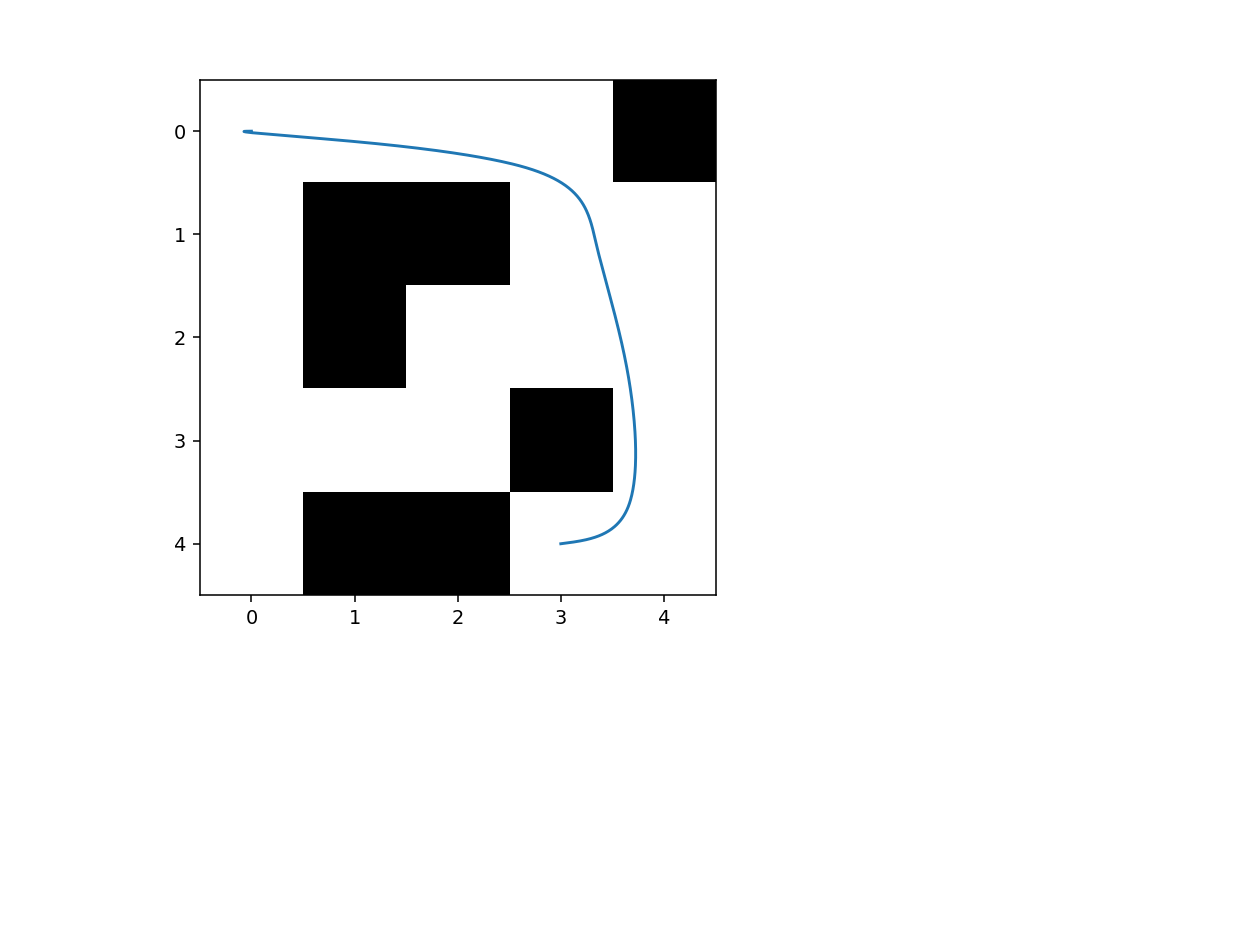

In [10]:
#Shortest Path from 1/3
start= (4,3)
end= (0,0)
#Find the start and stop nodes <- Could be improved
for i in range(len(graph_list)):
    if graph_list[i].isMember(start[1],start[0]):
        start_i = i
    if graph_list[i].isMember(end[1],end[0]):
        end_i = i
#Shortest path algorithm edges are important between corridors 
path = nx.shortest_path(G,list(G.nodes)[start_i],list(G.nodes)[end_i])
for i in range(len(path)-1):
    e = (path[i], path[i+1])
    G.remove_edge(*e) 
    G.add_edge(*e,color='r',weight=6)
plt.figure()
colors = nx.get_edge_attributes(G,'color').values()
nx.draw(G, with_labels = True,edge_color=colors)
#Left shift all the boxes
path = additionalBoundingBox(path)
new_path = []
#Left shift all the boxes
for i in range(len(path)):
    new_path.append(((path[i][0][0] - 0.5,path[i][0][1] - 0.5),path[i][1],path[i][2]))
path = boxShorten(0.3,new_path)
tf = np.ones(len(path))
#Coefficients
numberVar = len(path)*5
p = genCostNorm(4,2,1) + np.identity(5)*0.01
P = np.zeros((len(path)*5,len(path)*5))
for i in range(len(path)):
    P[5*i:5*(i+1),5*i:5*(i+1)] = p

#P = np.identity(numberVar)
q = np.zeros((numberVar))
A,b,Gm,h =  genBmatrix(path, start, end,tf,dim=1)
#P = genCostNorm(2,1)
coeff_x = quadprog_solve_qp(P, q, Gm, h, A, b)
A,b,Gm,h =  genBmatrix(path, start, end,tf,dim=0)
coeff_y = quadprog_solve_qp(P, q, Gm, h, A, b)
resolution = 500
x = np.zeros(resolution)
y = np.zeros(resolution)
t = np.linspace(0,len(path),num=resolution)
for i in range(resolution):
    x[i] = evalCoeff(t[i], tf, coeff_x,4)
    y[i] = evalCoeff(t[i], tf, coeff_y,4)

plt.figure()
plt.plot(t,x)
plt.figure()
plt.plot(t,y)
fig, ax = plt.subplots()
ax.imshow(1/(world_map+0.1), cmap='gray')
ax.plot(x,y)

<IPython.core.display.Javascript object>


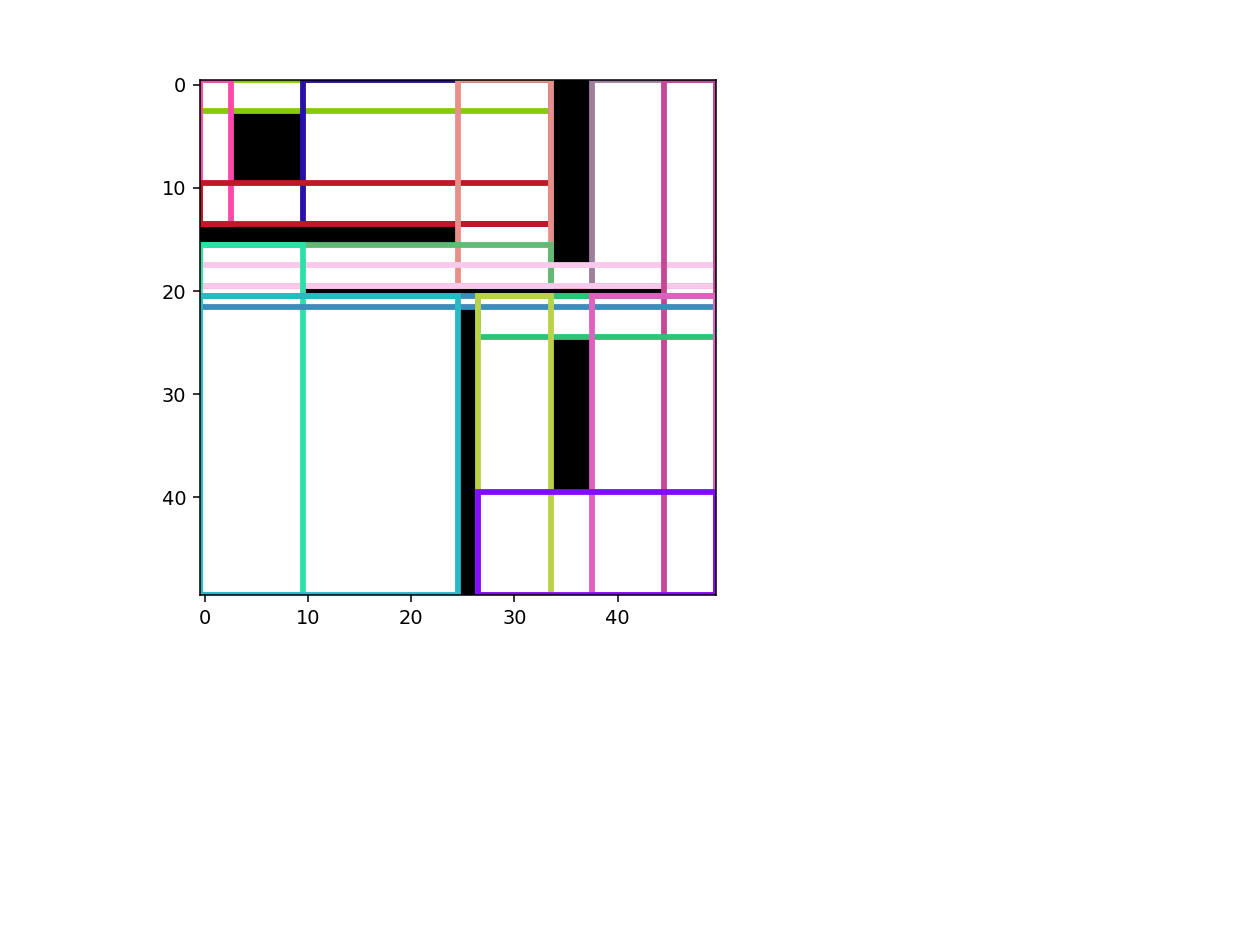

Number of corridors 16


<IPython.core.display.Javascript object>


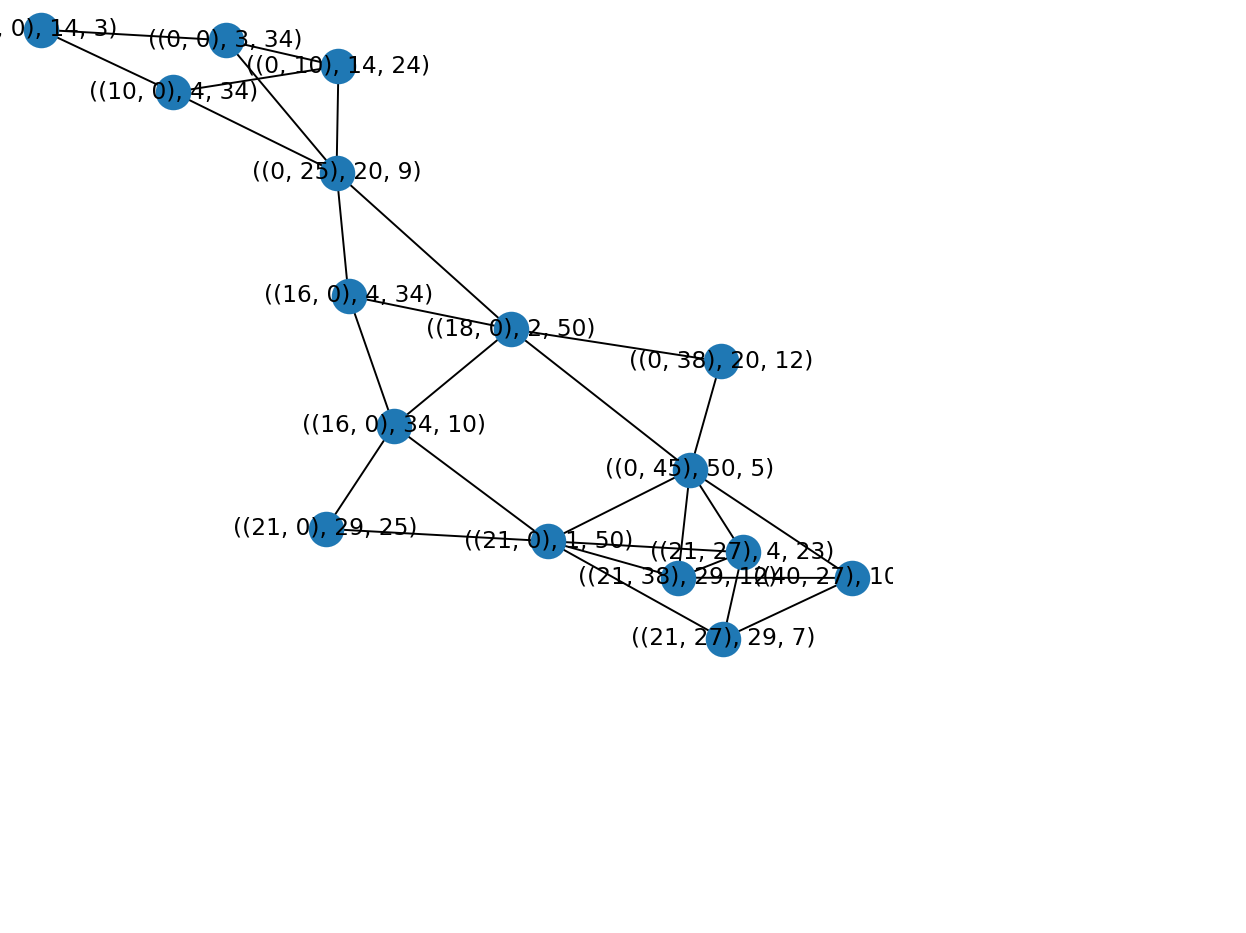

In [12]:
maze1 = np.load('maze1.npy')
import time
rect_list = solveSafeFlight(maze1)
#print(rect_list)
fig, ax = plt.subplots()
ax.imshow(1/(maze1+0.1), cmap='gray')
import random
number_of_colors = len(rect_list)
print("Number of corridors", len(rect_list))
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
    for i in range(number_of_colors)]
for i in range(len(rect_list)):
    rect_obj = rect_list[i]
    start = (rect_obj[0][1]-0.5,rect_obj[0][0]-0.5)
    rect = patches.Rectangle(start, rect_obj[2],rect_obj[1], linewidth=3, edgecolor=color[i], facecolor='none')
    ax.add_patch(rect)
plt.show()
graph_list = generateAdjList(rect_list);
#Add nodes
G = nx.Graph()
for i in range(len(graph_list)):
    G.add_node(graph_list[i].rect)
#Add edges
for i in range(len(graph_list)):
    curr_node = graph_list[i]
    start_str = graph_list[i].rect
    for j in range(len(curr_node.n)):
        end_str = graph_list[curr_node.n[j]].rect
        e = (start_str, end_str)
        G.add_edge(*e)
plt.figure()
nx.draw(G, with_labels = True)

[((0, 0), 14, 3), ((0, 0), 3, 34), ((0, 25), 20, 9), ((18, 0), 2, 50), ((0, 45), 50, 5), ((40, 27), 10, 23)]


<IPython.core.display.Javascript object>


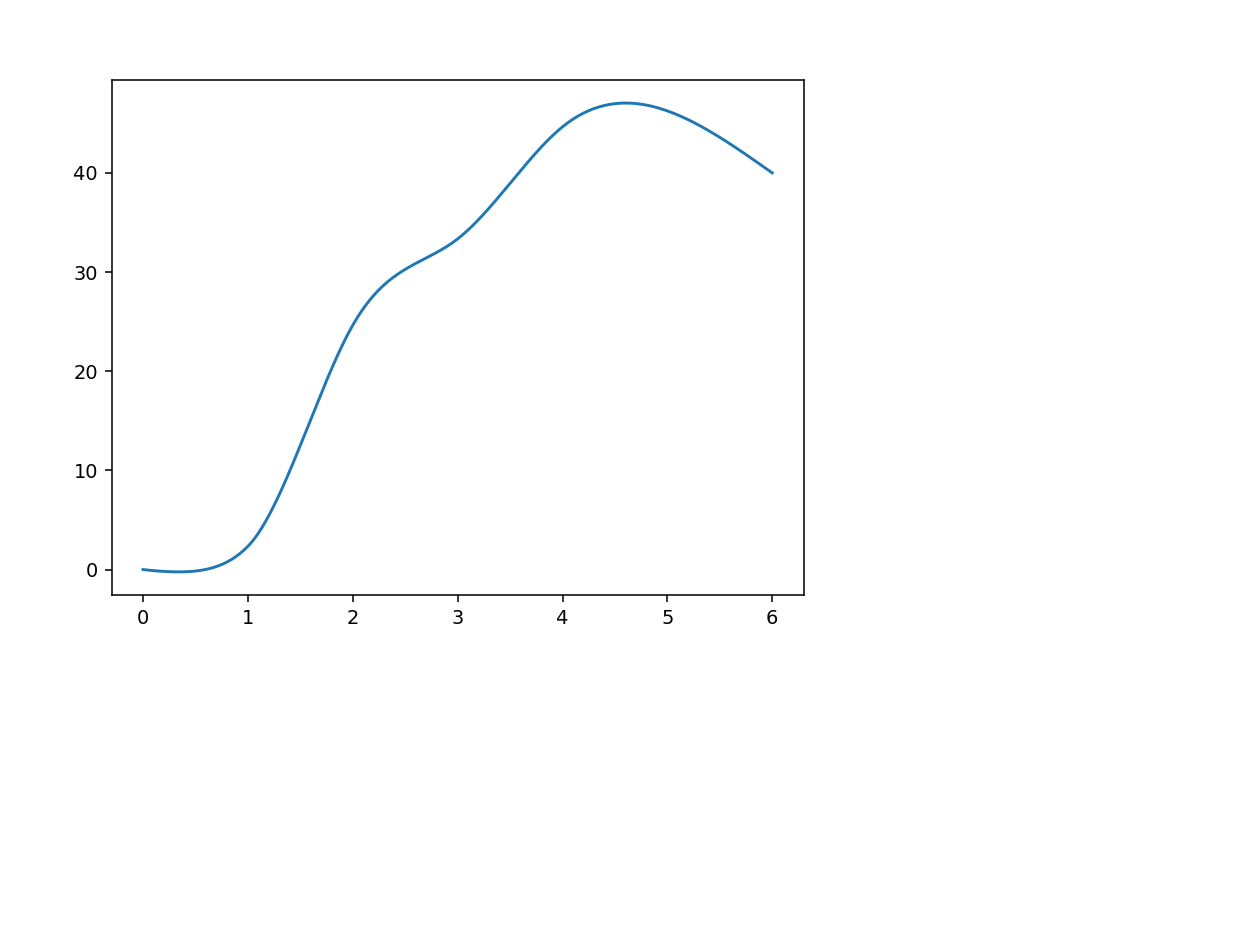

<IPython.core.display.Javascript object>


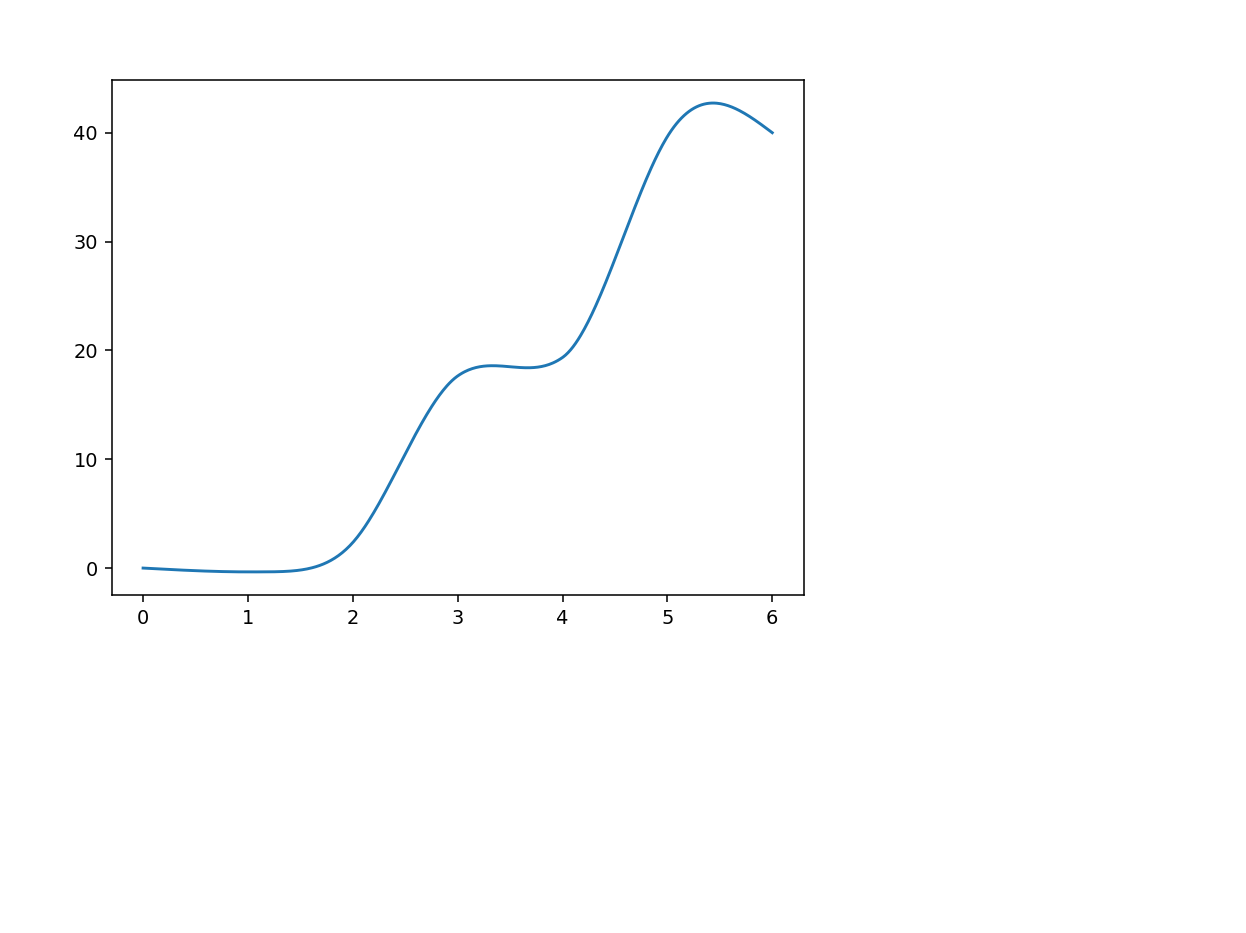

<IPython.core.display.Javascript object>


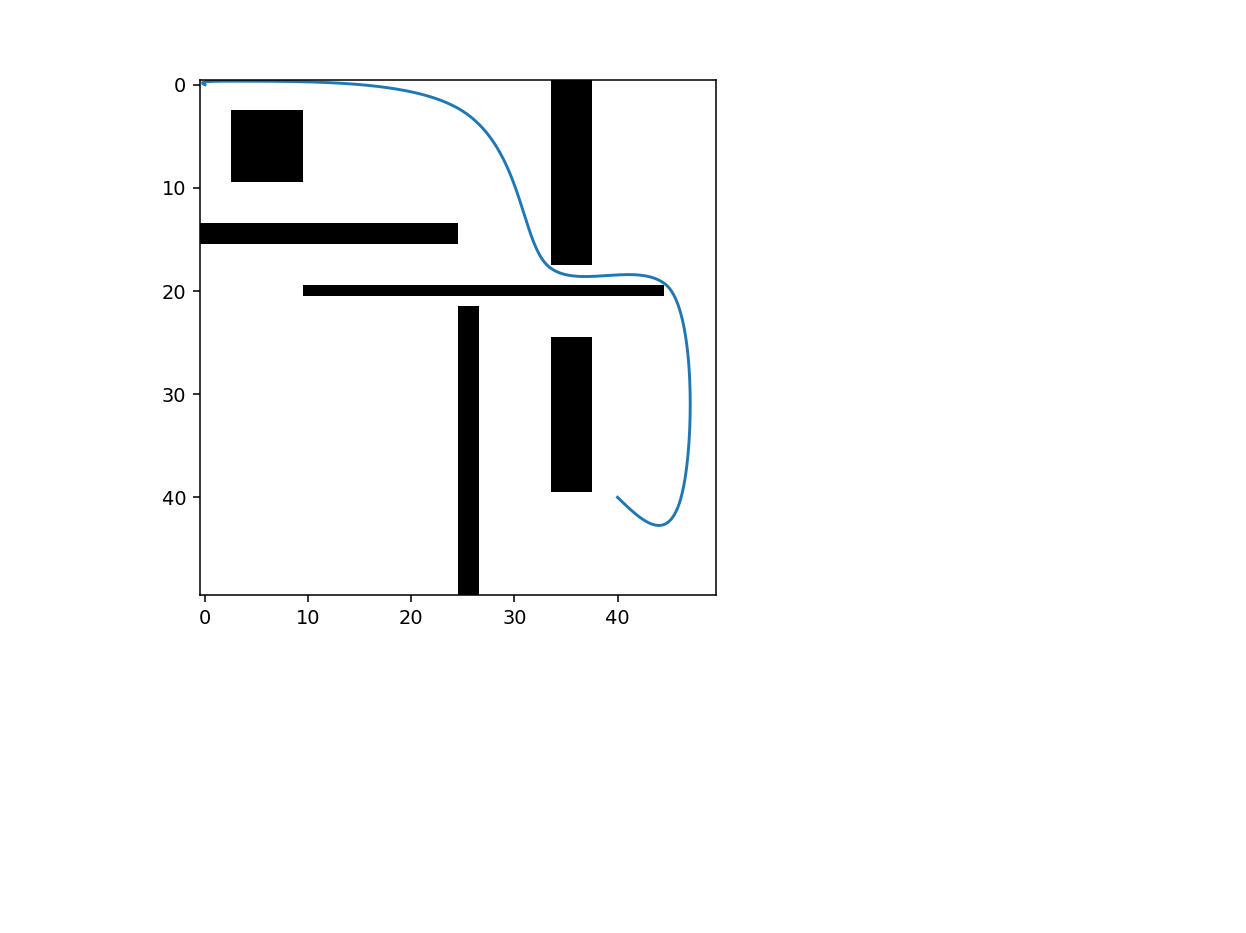

In [13]:
#Shortest Path from 1/3
start= (0, 0)
end= (40,40)
#Find the start and stop nodes <- Could be improved
for i in range(len(graph_list)):
    if graph_list[i].isMember(start[1],start[0]):
        start_i = i
    if graph_list[i].isMember(end[1],end[0]):
        end_i = i
#Shortest path algorithm edges are important between corridors 
path = nx.shortest_path(G,list(G.nodes)[start_i],list(G.nodes)[end_i])
print(path)
path = additionalBoundingBox(path)
new_path = []
#Left shift all the boxes
for i in range(len(path)):
    new_path.append(((path[i][0][0] - 0.5,path[i][0][1] - 0.5),path[i][1],path[i][2]))
path = boxShorten(0.3,new_path)
tf = np.ones(len(path))
#Coefficients
numberVar = len(path)*5
p = genCostNorm(4,2,1) + np.identity(5)*0.01
P = np.zeros((len(path)*5,len(path)*5))
for i in range(len(path)):
    P[5*i:5*(i+1),5*i:5*(i+1)] = p

#P = np.identity(numberVar)
q = np.zeros((numberVar))
A,b,Gm,h =  genBmatrix(path, start, end,tf,dim=1)
#P = genCostNorm(2,1)
coeff_x = quadprog_solve_qp(P, q, Gm, h, A, b)
A,b,Gm,h =  genBmatrix(path, start, end,tf,dim=0)
coeff_y = quadprog_solve_qp(P, q, Gm, h, A, b)
resolution = 500
x = np.zeros(resolution)
y = np.zeros(resolution)
t = np.linspace(0,len(path),num=resolution)
for i in range(resolution):
    x[i] = evalCoeff(t[i], tf, coeff_x,4)
    y[i] = evalCoeff(t[i], tf, coeff_y,4)

plt.figure()
plt.plot(t,x)
plt.figure()
plt.plot(t,y)
fig, ax = plt.subplots()
ax.imshow(1/(maze1+0.1), cmap='gray')
ax.plot(x,y)